In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.getcwd()+"/../src/")
import nesse
import numpy as np

In [2]:
import time

import tracemalloc

from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass


def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break

        else:
            if not hasattr(o.__class__, '__slots__'):
                if hasattr(o, '__dict__'):
                    s+=sizeof(o.__dict__) # no __slots__ *usually* means a __dict__, but some special builtin classes (such as `type(None)`) have neither
                # else, `o` has no attributes at all, so sys.getsizeof() actually returned the correct value
            else:
                s+=sum(sizeof(getattr(o, x)) for x in o.__class__.__slots__ if hasattr(o, x))
        return s

    return sizeof(o) / 1024

import linecache

def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

In [3]:
tracemalloc.start()
ID = "4"
# print(tracemalloc.get_traced_memory())

print(os.getcwd())

events_filename = "g:/nesse/config/Events/e-_800keV_0inc.root"
Events = nesse.eventsFromG4root(events_filename)[:1]

# print("Events:")
# print(tracemalloc.get_traced_memory())

EF_filename = "g:/nesse/config/Fields/4e10/NessieEF_Base4e7Linear0-150.0V.hf"
WP_filename = "g:/nesse/config/Fields/NessieWP_4e7Linear0-150V_grid.hf"


Efield=nesse.fieldFromH5(EF_filename, rotate90=True)  
# print("EField:")
# print(tracemalloc.get_traced_memory())


weightingPotential = nesse.potentialFromH5(WP_filename, rotate90=True)
print("WP:")
print(total_size(weightingPotential))
# print(tracemalloc.get_traced_memory())

print("Presim:")
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

sim = nesse.Simulation("Example_sim", 125, Efield, _weightingPotential=weightingPotential, contacts=1)

spiceFile= "g:/nesse/config/Spice/spice_step_full_1ns.csv"
sim.setElectronicResponse(spiceFile)

sim.setIDP(lambda x, y, z : float(ID) * 1e16)

ef_bounds = [[axis[0],axis[-1]] for axis in Efield.grid]
bounds = np.stack((ef_bounds[0],ef_bounds[1],[0,0.002]))
sim.setBounds(bounds)

print("Sim:")
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

g:\nesse\tests
WP:
3.849609375
Presim:
Top 10 lines
#1: g:\nesse\tests/../src\nesse\field.py:153: 19867.3 KiB
    Ez = np.rot90(np.array(f["Ez"]),axes=(0,2))
#2: g:\nesse\tests/../src\nesse\field.py:152: 19867.3 KiB
    Ey = np.rot90(np.array(f["Ey"]),axes=(0,2))
#3: g:\nesse\tests/../src\nesse\field.py:151: 19867.3 KiB
    Ex = np.rot90(np.array(f["Ex"]),axes=(0,2))
#4: g:\nesse\tests/../src\nesse\field.py:131: 16073.5 KiB
    data = np.array(f["wp"])
#5: <frozen importlib._bootstrap_external>:640: 9916.8 KiB
#6: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\site-packages\uproot\interpretation\library.py:75: 4608.6 KiB
    return numpy.empty(shape, dtype)
#7: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\site-packages\pandas\core\array_algos\take.py:157: 1675.9 KiB
    out = np.empty(out_shape, dtype=dtype)
#8: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\site-packages\pandas\core\indexes\range.py:209: 839.1 KiB
    return np.arange(self.start, self.stop, self.step, dtype=np.int64)
#9: c:\Users\RJ\

In [4]:
sim.setChargeCollectionEfficiency("soft",depth=70e-9)

sim.simulate(Events, ds=1e-6, diffusion=False, dt=1e-10, maxPairs=1, silence=True, parallel=False)

print("Postsim:")
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

print("-----------------------------------")
print(f"Events size: {total_size(Events)}")
print(f"Event size: {total_size(Events[0])}")
print(f"Quasiparticles size: {total_size(Events[0].quasiparticles)}")
print(f"Quasiparticle size: {total_size(Events[0].quasiparticles[0])}")
print(f"Quasiparticle pos size: {total_size(Events[0].quasiparticles[0].pos)}")

  0%|          | 0/1 [00:00<?, ?it/s]

Postsim:
Top 10 lines
#1: g:\nesse\tests/../src\nesse\field.py:153: 19867.3 KiB
    Ez = np.rot90(np.array(f["Ez"]),axes=(0,2))
#2: g:\nesse\tests/../src\nesse\field.py:152: 19867.3 KiB
    Ey = np.rot90(np.array(f["Ey"]),axes=(0,2))
#3: g:\nesse\tests/../src\nesse\field.py:151: 19867.3 KiB
    Ex = np.rot90(np.array(f["Ex"]),axes=(0,2))
#4: g:\nesse\tests/../src\nesse\field.py:131: 16073.5 KiB
    data = np.array(f["wp"])
#5: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\copy.py:153: 16073.4 KiB
    y = copier(memo)
#6: <frozen importlib._bootstrap_external>:640: 9939.1 KiB
#7: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\site-packages\uproot\interpretation\library.py:75: 4608.6 KiB
    return numpy.empty(shape, dtype)
#8: c:\Users\RJ\anaconda3\envs\nesse_dev\lib\site-packages\pandas\core\array_algos\take.py:157: 1675.9 KiB
    out = np.empty(out_shape, dtype=dtype)
#9: g:\nesse\tests/../src\nesse\quasiparticles.py:36: 1291.0 KiB
    self.pos = np.array(self.pos, dtype=np.float32)
#10: g:\ness

In [5]:
t0 = time.time()
sim.calculateInducedCurrent(Events, 1e-9, detailed=True)
t1 = time.time()
print(t1-t0)

1.205350399017334


In [6]:
sim.calculateElectronicResponse(Events)

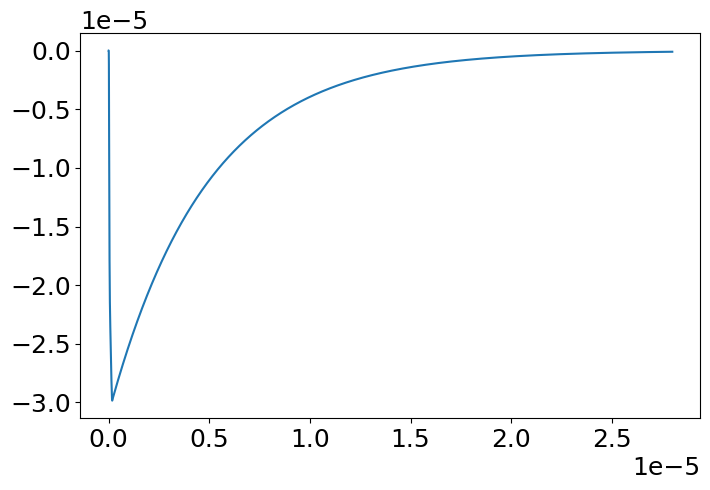

In [7]:
nesse.plot_signal(Events[0])

(0.0, 1e-06)

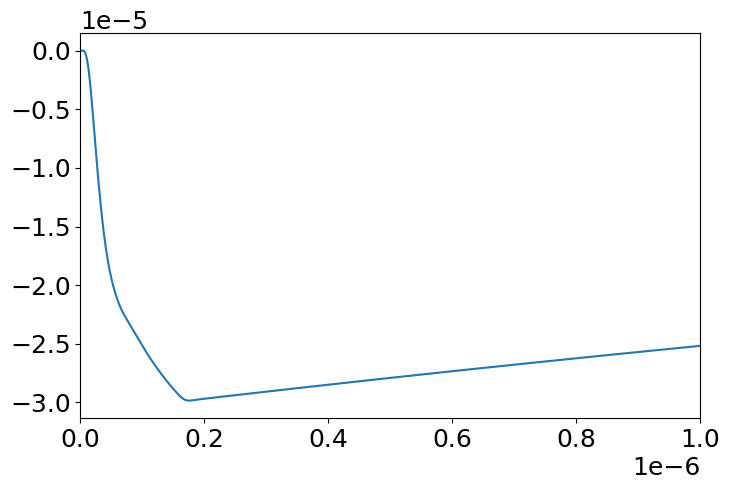

In [8]:
nesse.plot_signal(Events[0],show_plot=False)
nesse.plt.xlim(0,1000e-9)

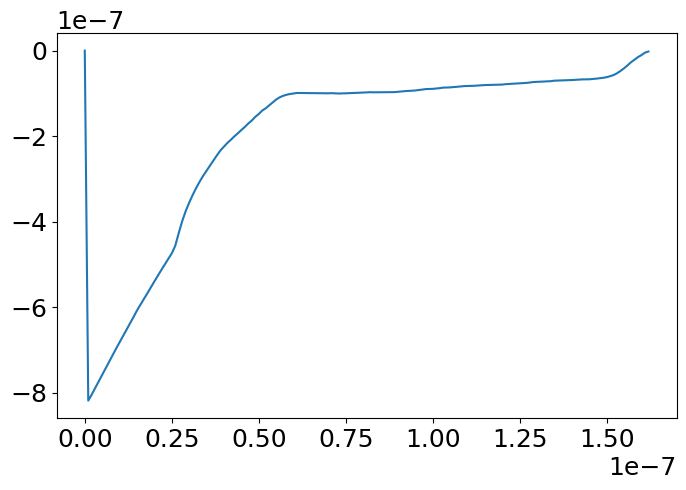

In [9]:
nesse.plot_current(Events[0],show_plot=False)